In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Create Spark session
spark = SparkSession.builder.appName("classification_comparison").getOrCreate()

# Load data into Spark DataFrame
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# Assemble features
features = [col for col in data.columns if col != 'cardio']
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)

# Split the data (80/20 and 70/30)
train_80, test_80 = data.randomSplit([0.8, 0.2], seed=42)
train_70, test_70 = data.randomSplit([0.7, 0.3], seed=42)

# Initialize models
lr = LogisticRegression(maxIter=10000, labelCol="cardio", featuresCol="features")
dt = DecisionTreeClassifier(labelCol="cardio", featuresCol="features")
rf = RandomForestClassifier(labelCol="cardio", featuresCol="features")

# Evaluate models with 5-fold cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
empty_param_grid = ParamGridBuilder().build()

# For 80/20 split
cv_lr_80 = CrossValidator(estimator=lr, estimatorParamMaps=empty_param_grid, evaluator=evaluator, numFolds=5)
cv_dt_80 = CrossValidator(estimator=dt, estimatorParamMaps=empty_param_grid, evaluator=evaluator, numFolds=5)
cv_rf_80 = CrossValidator(estimator=rf, estimatorParamMaps=empty_param_grid, evaluator=evaluator, numFolds=5)

lr_avg_80 = cv_lr_80.fit(train_80).avgMetrics[0]
dt_avg_80 = cv_dt_80.fit(train_80).avgMetrics[0]
rf_avg_80 = cv_rf_80.fit(train_80).avgMetrics[0]

# For 70/30 split
cv_lr_70 = CrossValidator(estimator=lr, estimatorParamMaps=empty_param_grid, evaluator=evaluator, numFolds=5)
cv_dt_70 = CrossValidator(estimator=dt, estimatorParamMaps=empty_param_grid, evaluator=evaluator, numFolds=5)
cv_rf_70 = CrossValidator(estimator=rf, estimatorParamMaps=empty_param_grid, evaluator=evaluator, numFolds=5)

lr_avg_70 = cv_lr_70.fit(train_70).avgMetrics[0]
dt_avg_70 = cv_dt_70.fit(train_70).avgMetrics[0]
rf_avg_70 = cv_rf_70.fit(train_70).avgMetrics[0]

# Print results
print("80/20 Split Cross-Validation Results:")
print("Logistic Regression:", lr_avg_80)
print("Decision Tree:", dt_avg_80)
print("Random Forest:", rf_avg_80)

print("\n70/30 Split Cross-Validation Results:")
print("Logistic Regression:", lr_avg_70)
print("Decision Tree:", dt_avg_70)
print("Random Forest:", rf_avg_70)


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/08 23:12:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/08 23:13:13 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/08 23:13:13 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


80/20 Split Cross-Validation Results:
Logistic Regression: 0.7204173183807678
Decision Tree: 0.718918514357006
Random Forest: 0.720399625304261

70/30 Split Cross-Validation Results:
Logistic Regression: 0.7198918147731901
Decision Tree: 0.718102159725833
Random Forest: 0.7205659891241211


In [2]:
# 7.2 Logistic Regression 
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create a Spark session
spark = SparkSession.builder.appName("logistic_regression").getOrCreate()

# Load the data into a Spark DataFrame
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# Assemble the features
features = [col for col in data.columns if col != 'cardio']
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Initialize and fit the logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="cardio", maxIter=10000)
lr_model = lr.fit(train_data)

# Predict and evaluate the accuracy
predictions = lr_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="cardio")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("Logistic Regression Accuracy:", accuracy)

# Retrieve the coefficients for each feature in the logistic regression model
coefficients = lr_model.coefficients
feature_coefficients = dict(zip(features, coefficients))
sorted_feature_coefficients = dict(sorted(feature_coefficients.items(), key=lambda item: item[1], reverse=True))
print("Feature coefficients for Logistic Regression:\n", sorted_feature_coefficients)

Logistic Regression Accuracy: 0.7858251821071432
Feature coefficients for Logistic Regression:
 {'cholesterol': 0.6220629937932689, 'ap_hi': 0.054657099530976944, 'age': 0.05267021800522229, 'BMI': 0.0322019328336178, 'ap_lo': 0.028400577192131234, 'gender': -0.035205101793474934, 'glucose': -0.07685566873003605, 'smoke': -0.13708029788876513, 'alcohol': -0.20171506865387742, 'active': -0.22996990504325016}


In [3]:
# Confusion Matrix & Confusion Matrix
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics

# 1. Convert 'cardio' column to double type
data = data.withColumn("cardio", col("cardio").cast("double"))

# 2. Assemble features using VectorAssembler
if "features_vec" in data.columns:
    data = data.drop("features_vec")

features = ['age', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'gender', 'BMI']
assembler = VectorAssembler(inputCols=features, outputCol="features_vec")
data = assembler.transform(data)

# Remove "scaled_features" column if it exists
if "scaled_features" in data.columns:
    data = data.drop("scaled_features")

# 3. Scale the features
scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features")
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

# 4. Split the data
train, test = data.randomSplit([0.8, 0.2], seed=42)

# 5. Train logistic regression model
lr = LogisticRegression(featuresCol="scaled_features", labelCol="cardio", maxIter=10000)
lr_model = lr.fit(train)
predictions = lr_model.transform(test)

# 6. Get the prediction and label columns
predictionAndLabels = predictions.select("prediction", "cardio").rdd

# 7. Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# 8. Print confusion matrix and other metrics
print("Confusion Matrix:")
print(metrics.confusionMatrix().toArray())

labels = [0.0, 1.0]
for label in labels:
    print(f"\nMetrics for label {label}:")
    print(f"Precision = {metrics.precision(label)}")
    print(f"Recall = {metrics.recall(label)}")
    print(f"F1 Score = {metrics.fMeasure(label)}")


/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:


[[5441. 1606.]
 [2240. 4620.]]

Metrics for label 0.0:
Precision = 0.7083713058195548
Recall = 0.7721016035192281
F1 Score = 0.7388647474198805

Metrics for label 1.0:
Precision = 0.7420494699646644
Recall = 0.673469387755102
F1 Score = 0.7060981201283815


/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


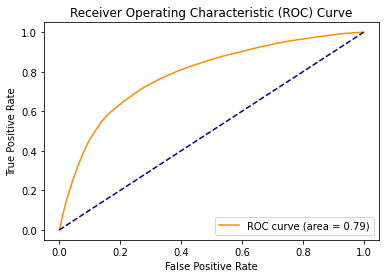

In [4]:
#ROC Curve and AUC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt

# Assuming 'predictions' is the DataFrame from your Logistic Regression prediction
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="cardio", metricName="areaUnderROC")

# Fetch the ROC as a DataFrame
roc_df = lr_model.summary.roc

# Extract FPR and TPR
fpr = roc_df.select("FPR").rdd.flatMap(lambda x: x).collect()
tpr = roc_df.select("TPR").rdd.flatMap(lambda x: x).collect()

roc_auc = evaluator.evaluate(predictions)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [5]:
#RFE
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler

def rfe(spark_df, feature_cols, label_col, num_features_to_select):
    def assemble_features(data, input_cols):
        assembler = VectorAssembler(inputCols=input_cols, outputCol="rfe_features")
        return assembler.transform(data).select("rfe_features", label_col)

    train = assemble_features(spark_df, feature_cols)

    # Create logistic regression model
    lr = LogisticRegression(featuresCol="rfe_features", labelCol=label_col, maxIter=10000)

    # Iteratively train the model and drop least important features
    for _ in range(len(feature_cols) - num_features_to_select):
        # Train the model
        model = lr.fit(train)

        # Get feature importances or use coefficients in case of logistic regression
        coefficients = model.coefficients.toArray()

        # Find the feature with the smallest coefficient (in absolute value)
        min_coeff_idx = min(range(len(coefficients)), key=lambda x: abs(coefficients[x]))

        # Drop that feature
        feature_cols.pop(min_coeff_idx)

        # Reassemble with reduced features
        train = assemble_features(spark_df, feature_cols)

    return feature_cols

# Assuming your DataFrame is named 'data' and features are assembled in 'scaled_features'
X_cols = ['age', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'gender', 'BMI']
y_col = "cardio"
top_features = rfe(data, X_cols, y_col, 5)

print("Top 5 Features selected by RFE:", top_features)


Top 5 Features selected by RFE: ['ap_hi', 'cholesterol', 'smoke', 'alcohol', 'active']


In [6]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

# Initialize logistic regression model
lr = LogisticRegression(featuresCol="scaled_features", labelCol="cardio", maxIter=10000)

# Set up the hyperparameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.001, 0.01, 0.1, 1, 10, 100]) \
    .build()

# Initialize a binary classification evaluator (assuming the problem is binary classification)
evaluator = BinaryClassificationEvaluator(labelCol="cardio")

# Set up 5-fold cross validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Train model with the dataset
cvModel = crossval.fit(train)

# Fetch best model and its metrics
bestModel = cvModel.bestModel
bestRegParam = bestModel.getOrDefault("regParam")
print(f"Best RegParam: {bestRegParam}")

# Fetch average metrics across all models in the grid
avgMetrics = cvModel.avgMetrics
print(f"Best Cross-Validation Score: {max(avgMetrics)}")

# Evaluate on test set
predictions = bestModel.transform(test)
accuracy = evaluator.evaluate(predictions)
print(f"Best Logistic Regression Accuracy on Test Set: {accuracy}")

Best RegParam: 0.001
Best Cross-Validation Score: 0.7853688267227475


Best Logistic Regression Accuracy on Test Set: 0.7858239513040528


In [7]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Start a Spark session
spark = SparkSession.builder.appName("DecisionTreeWithSpark").getOrCreate()

# Load the dataset
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# Data Preparation: Separating features and target
features = [col for col in data.columns if col != 'cardio']
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)

# Splitting the data into a training set and test set (80/20 split)
(train_data, test_data) = data.randomSplit([0.8, 0.2], seed=42)

# Initializing DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="cardio", featuresCol="features")

# Hyperparameter Tuning and Model Optimization
# Defining hyperparameters grid to search
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [3, 5, 6, 7, 10])
             .addGrid(dt.maxBins, [16, 32, 64, 128, 256])
             .addGrid(dt.impurity, ['gini', 'entropy'])
             .build())

# Set up the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")

# Setting up the CrossValidator
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Fitting the model
cvModel = crossval.fit(train_data)

# Evaluating the optimized decision tree model
predictions = cvModel.transform(test_data)
accuracy = evaluator.evaluate(predictions)

# Display results
print("Optimized Decision Tree Accuracy:", accuracy)

# Extracting and Displaying Feature Importances from the Optimized Model
best_tree = cvModel.bestModel
feature_importances_optimized = best_tree.featureImportances
importances_list = [(feature, importance) for feature, importance in zip(features, feature_importances_optimized)]
importances_sorted = sorted(importances_list, key=lambda x: x[1], reverse=True)
print("\nOptimized Decision Tree - Feature importances:")
for feat, imp in importances_sorted:
    print(f"{feat}: {imp}")


Optimized Decision Tree Accuracy: 0.7261091536636226

Optimized Decision Tree - Feature importances:
ap_hi: 0.7514731840949104
age: 0.1468193013740795
cholesterol: 0.058160310940359596
ap_lo: 0.022063272324391044
BMI: 0.014555646284188699
active: 0.003108056717534067
glucose: 0.0022094433571188225
smoke: 0.0010581473854411269
alcohol: 0.0005526375219767928
gender: 0.0


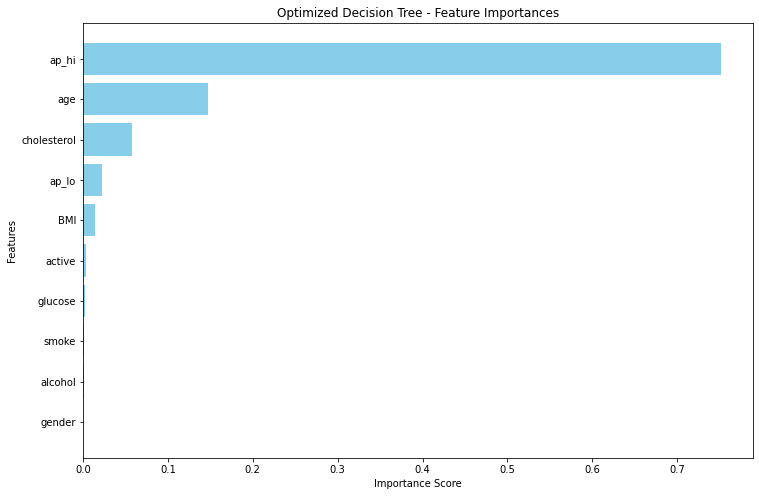

In [8]:
import matplotlib.pyplot as plt

# Extracting the feature names and their importance scores
features, importances = zip(*importances_sorted)

# Plotting the feature importances
plt.figure(figsize=(12,8))
plt.barh(features, importances, align='center', color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Optimized Decision Tree - Feature Importances')
plt.gca().invert_yaxis()  # To display the feature with the highest importance at the top
plt.show()

In [9]:
print("Decision Tree Structure:")
print(best_tree.toDebugString)

Decision Tree Structure:
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ce32ba721df0, depth=7, numNodes=127, numClasses=2, numFeatures=10
  If (feature 2 <= 129.5)
   If (feature 0 <= 54.5)
    If (feature 4 <= 0.5)
     If (feature 0 <= 44.5)
      If (feature 2 <= 114.5)
       Predict: 0.0
      Else (feature 2 > 114.5)
       If (feature 3 <= 90.5)
        Predict: 0.0
       Else (feature 3 > 90.5)
        Predict: 1.0
     Else (feature 0 > 44.5)
      If (feature 2 <= 119.0)
       Predict: 0.0
      Else (feature 2 > 119.0)
       If (feature 3 <= 96.0)
        Predict: 0.0
       Else (feature 3 > 96.0)
        If (feature 9 <= 22.4655)
         Predict: 0.0
        Else (feature 9 > 22.4655)
         Predict: 1.0
    Else (feature 4 > 0.5)
     If (feature 2 <= 119.0)
      If (feature 9 <= 21.5295)
       If (feature 2 <= 111.5)
        Predict: 0.0
       Else (feature 2 > 111.5)
        Predict: 1.0
      Else (feature 9 > 21.5295)
       If (feature 3 <= 84.5


Confusion Matrix for Optimized Decision Tree:


[[5598. 1449.]
 [2439. 4421.]]

Classification Report for Optimized Decision Tree:
Precision for class 0: 0.696528555431131
Recall for class 0: 0.7943805874840357
F1 Score for class 0: 0.7422434367541767

Precision for class 1: 0.7531516183986371
Recall for class 1: 0.644460641399417
F1 Score for class 1: 0.6945797329143755


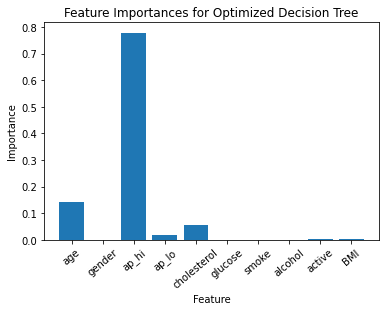

AUC for Decision Tree: 0.6159505047533822


In [17]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Start Spark session
spark = SparkSession.builder.appName("DecisionTreeWithSpark").getOrCreate()

# Load the dataset
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# Rename the 'cardio' column to 'label'
data = data.withColumnRenamed("cardio", "label")

# Convert 'label' column to DoubleType
data = data.withColumn("label", col("label").cast("double"))

# Assemble features into a single vector column
features = [col for col in data.columns if col != 'label']
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)

# Split data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Initialize and fit the decision tree classifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model = dt.fit(train_data)
predictions = model.transform(test_data)

# Compute raw scores on the test set
predictionAndLabels = predictions.select("prediction", "label").rdd

# Compute metrics
metrics = MulticlassMetrics(predictionAndLabels)

# Display confusion matrix
print("\nConfusion Matrix for Optimized Decision Tree:")
print(metrics.confusionMatrix().toArray())

# Display classification report metrics
print("\nClassification Report for Optimized Decision Tree:")
print(f"Precision for class 0: {metrics.precision(0)}")
print(f"Recall for class 0: {metrics.recall(0)}")
print(f"F1 Score for class 0: {metrics.fMeasure(0.0)}")

print(f"\nPrecision for class 1: {metrics.precision(1)}")
print(f"Recall for class 1: {metrics.recall(1)}")
print(f"F1 Score for class 1: {metrics.fMeasure(1.0)}")

# Extract and display feature importances
importances = model.featureImportances.toArray()
feature_names = features
x_values = list(range(len(importances)))

# Plot feature importances
plt.bar(x_values, importances, orientation='vertical')
plt.xticks(x_values, feature_names, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances for Optimized Decision Tree')
plt.show()

# Evaluate AUC
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(predictions)
print(f"AUC for Decision Tree: {auc}")

In [12]:
# Random Forest Option1:
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import VectorAssembler

# Start a Spark session
spark = SparkSession.builder.appName("OptimizedRandomForestEvaluation").getOrCreate()

# Load the data (assuming you have it in the same path)
data_path = 'redu4.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)

from pyspark.sql.functions import col

df = df.withColumn("cardio", col("cardio").cast("double"))


# Preparing the data: Assemble features into a single vector column
features = [col for col in df.columns if col != 'cardio']
assembler = VectorAssembler(inputCols=features, outputCol="features")
df = assembler.transform(df)

# Splitting the data into a training set and test set (assuming an 80/20 split)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Initialize the best Random Forest model with provided parameters
best_rf = RandomForestClassifier(
    numTrees=20,
    maxDepth=5,
    minInstancesPerNode=1,
    impurity="gini",
    featureSubsetStrategy="auto",
    seed=42,
    labelCol="cardio",
    featuresCol="features"
)

# Train the model
rf_model = best_rf.fit(train_data)

# Make predictions
predictions = rf_model.transform(test_data)

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", metricName="accuracy")
accuracy_rf = evaluator.evaluate(predictions)
print("Optimized Random Forest Accuracy:", accuracy_rf)

# Display the confusion matrix
predictionAndLabels = predictions.select("prediction", "cardio").rdd
metrics = MulticlassMetrics(predictionAndLabels)
confusion_rf = metrics.confusionMatrix().toArray()
print("\nConfusion Matrix for Optimized Random Forest:\n", confusion_rf)

# Display the classification report
print("\nClassification Report for Optimized Random Forest:")
print("Precision for class 0:", metrics.precision(0))
print("Recall for class 0:", metrics.recall(0))
print("F1 Score for class 0:", metrics.fMeasure(0.0))
print("Precision for class 1:", metrics.precision(1))
print("Recall for class 1:", metrics.recall(1))
print("F1 Score for class 1:", metrics.fMeasure(1.0))

# Display feature importances
importances = rf_model.featureImportances
importance_dict = {feature: importance for feature, importance in zip(features, importances)}
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
print("\nFeature importances from Optimized Random Forest:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")


Optimized Random Forest Accuracy: 0.7213633422017689



Confusion Matrix for Optimized Random Forest:
 [[5499. 1548.]
 [2327. 4533.]]

Classification Report for Optimized Random Forest:
Precision for class 0: 0.7026578073089701
Recall for class 0: 0.7803320561941252
F1 Score for class 0: 0.7394607678343307
Precision for class 1: 0.7454366058214109
Recall for class 1: 0.6607871720116618
F1 Score for class 1: 0.7005640986013445

Feature importances from Optimized Random Forest:
ap_hi: 0.5810802686074845
ap_lo: 0.2391904327413031
age: 0.08948167060905599
cholesterol: 0.07600172392914026
BMI: 0.0092600252629552
glucose: 0.0032885580761973835
smoke: 0.0006953124750333475
active: 0.0006826762515274525
alcohol: 0.0002496227695895809
gender: 6.970927771313408e-05


In [13]:
# Random Forest Option2:
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import VectorAssembler

# Start a Spark session
spark = SparkSession.builder.appName("OptimizedRandomForestEvaluation").getOrCreate()

# Load the data (assuming you have it in the same path)
data_path = 'redu4.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)

from pyspark.sql.functions import col

df = df.withColumn("cardio", col("cardio").cast("double"))

# Preparing the data: Assemble features into a single vector column
features = [col for col in df.columns if col != 'cardio']
assembler = VectorAssembler(inputCols=features, outputCol="features")
df = assembler.transform(df)

# Splitting the data into a training set and test set (assuming an 80/20 split)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Initialize the best Random Forest model with provided parameters
best_rf = RandomForestClassifier(
    numTrees=100,
    maxDepth=10,
    minInstancesPerNode=1,
    impurity="gini",
    featureSubsetStrategy="auto",
    seed=42,
    labelCol="cardio",
    featuresCol="features"
)

# Train the model
rf_model = best_rf.fit(train_data)

# Make predictions
predictions = rf_model.transform(test_data)

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", metricName="accuracy")
accuracy_rf = evaluator.evaluate(predictions)
print("Optimized Random Forest Accuracy:", accuracy_rf)

# Save accuracy to a variable or file if needed
# For example, save to a file
with open("accuracy_rf.txt", "w") as f:
    f.write(str(accuracy_rf))

# Display the confusion matrix
predictionAndLabels = predictions.select("prediction", "cardio").rdd
metrics = MulticlassMetrics(predictionAndLabels)
confusion_rf = metrics.confusionMatrix().toArray()
print("\nConfusion Matrix for Optimized Random Forest:\n", confusion_rf)

# Display the classification report
print("\nClassification Report for Optimized Random Forest:")
print("Precision for class 0:", metrics.precision(0))
print("Recall for class 0:", metrics.recall(0))
print("F1 Score for class 0:", metrics.fMeasure(0.0))
print("Precision for class 1:", metrics.precision(1))
print("Recall for class 1:", metrics.recall(1))
print("F1 Score for class 1:", metrics.fMeasure(1.0))

# Display feature importances
importances = rf_model.featureImportances
importance_dict = {feature: importance for feature, importance in zip(features, importances)}
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
print("\nFeature importances from Optimized Random Forest:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")


23/10/08 23:50:53 WARN DAGScheduler: Broadcasting large task binary with size 1737.0 KiB
23/10/08 23:50:58 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/10/08 23:51:03 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
23/10/08 23:51:08 WARN DAGScheduler: Broadcasting large task binary with size 1487.2 KiB
23/10/08 23:51:10 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/10/08 23:51:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/08 23:51:17 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


Optimized Random Forest Accuracy: 0.7277629970518444


23/10/08 23:51:19 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
23/10/08 23:51:20 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB



Confusion Matrix for Optimized Random Forest:
 [[5464. 1583.]
 [2203. 4657.]]

Classification Report for Optimized Random Forest:
Precision for class 0: 0.7126646667536194
Recall for class 0: 0.7753654037178941
F1 Score for class 0: 0.7426940328938426
Precision for class 1: 0.7463141025641026
Recall for class 1: 0.678862973760933
F1 Score for class 1: 0.7109923664122137

Feature importances from Optimized Random Forest:
ap_hi: 0.5052117613016671
ap_lo: 0.18736436934766393
age: 0.14960732323728293
cholesterol: 0.06610433710907991
BMI: 0.055160484723381975
active: 0.010012183171185272
glucose: 0.008305734237362524
smoke: 0.006305134996697492
gender: 0.006279033998456342
alcohol: 0.005649637877222492


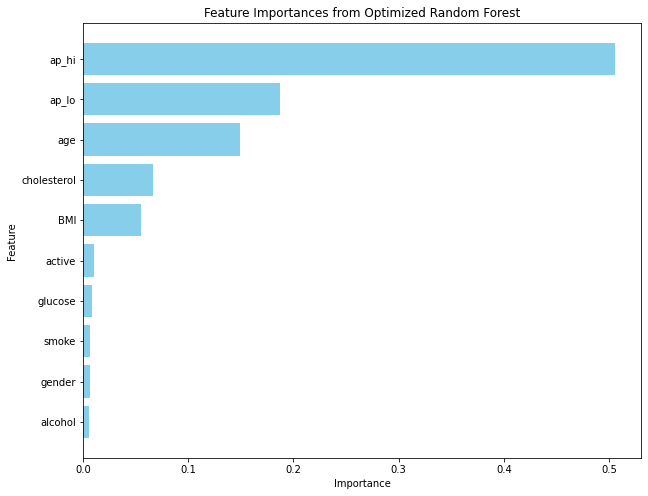

In [14]:
import matplotlib.pyplot as plt

# Given feature importances
feature_importances = {
    "ap_hi": 0.5052117613016671,
    "ap_lo": 0.18736436934766393,
    "age": 0.14960732323728293,
    "cholesterol": 0.06610433710907991,
    "BMI": 0.055160484723381975,
    "active": 0.010012183171185272,
    "glucose": 0.008305734237362524,
    "smoke": 0.006305134996697492,
    "gender": 0.006279033998456342,
    "alcohol": 0.005649637877222492
}

# Sorting feature importances
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
features = [item[0] for item in sorted_features]
importances = [item[1] for item in sorted_features]

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Optimized Random Forest')
plt.gca().invert_yaxis()  # to display the feature with the highest importance at the top
plt.show()

23/10/09 00:10:03 WARN DAGScheduler: Broadcasting large task binary with size 1735.6 KiB
23/10/09 00:10:08 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/10/09 00:10:14 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
23/10/09 00:10:19 WARN DAGScheduler: Broadcasting large task binary with size 1480.0 KiB
23/10/09 00:10:21 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
23/10/09 00:10:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/09 00:10:29 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


Optimized Random Forest Accuracy: 0.7277629970518444


23/10/09 00:10:31 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


AUC: 0.7945121903289081


23/10/09 00:10:32 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


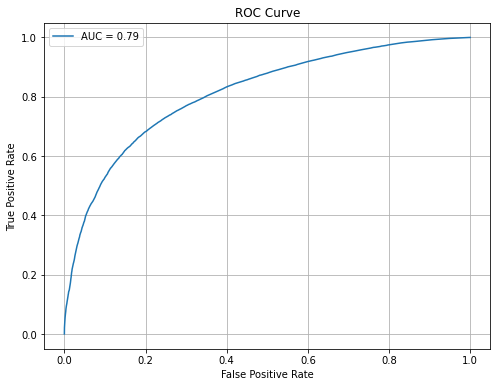

23/10/09 00:10:36 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/10/09 00:10:37 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB



Confusion Matrix for Optimized Random Forest:
 [[5458. 1589.]
 [2197. 4663.]]

Classification Report for Optimized Random Forest:
Precision for class 0: 0.7129980404964076
Recall for class 0: 0.7745139775791117
F1 Score for class 0: 0.742484015780166
Precision for class 1: 0.7458413307741523
Recall for class 1: 0.679737609329446
F1 Score for class 1: 0.7112568639414277

Feature importances from Optimized Random Forest:
ap_hi: 0.49749276606633197
ap_lo: 0.19830888644833103
age: 0.14728114068117162
cholesterol: 0.0682768728296381
BMI: 0.052026654294594445
active: 0.01036582748623665
glucose: 0.008158110485204905
smoke: 0.006297189548113173
gender: 0.006086885578072104
alcohol: 0.005705666582306084


In [16]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Start a Spark session
spark = SparkSession.builder.appName("OptimizedRandomForestEvaluation").getOrCreate()

# Load the data
data_path = 'redu4.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)

df = df.withColumn("cardio", col("cardio").cast("double"))

# Preparing the data: Assemble features into a single vector column
features = [col for col in df.columns if col != 'cardio']
assembler = VectorAssembler(inputCols=features, outputCol="features")
df = assembler.transform(df)

# Splitting the data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Initialize the Random Forest model with provided parameters
best_rf = RandomForestClassifier(
    numTrees=100,
    maxDepth=10,
    labelCol="cardio",
    featuresCol="features"
)

# Train the model
rf_model = best_rf.fit(train_data)

# Make predictions
predictions = rf_model.transform(test_data)

# Evaluate accuracy
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="cardio", metricName="accuracy")
accuracy_rf = evaluator_accuracy.evaluate(predictions)
print("Optimized Random Forest Accuracy:", accuracy_rf)

# Calculate AUC
evaluator_auc = BinaryClassificationEvaluator(labelCol="cardio")
auc = evaluator_auc.evaluate(predictions)
print(f"AUC: {auc}")

# Extract the ROC curve using Spark API
roc = rf_model.summary.roc.collect()

# Split the ROC into FPR and TPR
fpr = [row['FPR'] for row in roc]
tpr = [row['TPR'] for row in roc]

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Display the confusion matrix
predictionAndLabels = predictions.select("prediction", "cardio").rdd
metrics = MulticlassMetrics(predictionAndLabels)
confusion_rf = metrics.confusionMatrix().toArray()
print("\nConfusion Matrix for Optimized Random Forest:\n", confusion_rf)

# Display the classification report
print("\nClassification Report for Optimized Random Forest:")
print("Precision for class 0:", metrics.precision(0))
print("Recall for class 0:", metrics.recall(0))
print("F1 Score for class 0:", metrics.fMeasure(0.0))
print("Precision for class 1:", metrics.precision(1))
print("Recall for class 1:", metrics.recall(1))
print("F1 Score for class 1:", metrics.fMeasure(1.0))

# Display feature importances
importances = rf_model.featureImportances
importance_dict = {feature: importance for feature, importance in zip(features, importances)}
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
print("\nFeature importances from Optimized Random Forest:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/09 00:47:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/09 00:48:16 WARN BlockManager: Asked to remove block broadcast_96, which does not exist


Random Forest Cross-Validated Accuracy: 0.7220


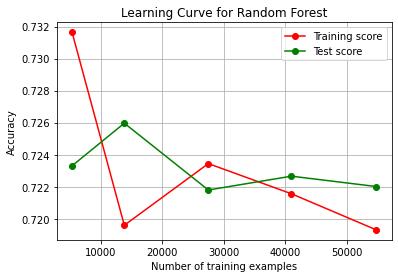

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Start a Spark session
spark = SparkSession.builder.appName("RandomForestWithSpark").getOrCreate()

# Load the dataset
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# Data Preparation: Separating features and target
features = [col for col in data.columns if col != 'cardio']
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)

# Splitting the data into a training set and test set (80/20 split)
(train_data, test_data) = data.randomSplit([0.8, 0.2], seed=42)

# Initialize the Random Forest model (you'll need to define its parameters)
rf = RandomForestClassifier(labelCol="cardio", featuresCol="features")

# For cross-validated accuracy
paramGrid = ParamGridBuilder().build()  # No parameters to tune for this step
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = crossval.fit(train_data)
predictions = cvModel.transform(test_data)
accuracy = evaluator.evaluate(predictions)
print(f"Random Forest Cross-Validated Accuracy: {accuracy:.4f}")

# For the learning curve
train_fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
train_sizes = []
train_scores = []
test_scores = []

for fraction in train_fractions:
    sample_data = train_data.sample(withReplacement=False, fraction=fraction)
    model = rf.fit(sample_data)
    
    train_pred = model.transform(sample_data)
    test_pred = model.transform(test_data)
    
    train_accuracy = evaluator.evaluate(train_pred)
    test_accuracy = evaluator.evaluate(test_pred)
    
    train_sizes.append(sample_data.count())
    train_scores.append(train_accuracy)
    test_scores.append(test_accuracy)

# Now you can plot the results using matplotlib or any other Python plotting library
# This code won't run on Spark, but it's required to visualize the learning curve

import matplotlib.pyplot as plt

plt.plot(train_sizes, train_scores, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores, 'o-', color='g', label='Test score')
plt.title('Learning Curve for Random Forest')
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [11]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

spark = SparkSession.builder.appName("InteractionAnalysisWithSpark").getOrCreate()

# Load the dataset
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# Define all unique features for which you want to create interactions
features = ["age", "ap_hi", "ap_lo", "cholesterol", "glucose", "smoke", "alcohol", "active", "gender", "BMI"]

# Create interaction terms based on distinct features
interaction_terms = [(feat1, feat2) for i, feat1 in enumerate(features) for j, feat2 in enumerate(features) if i <= j]

significant_interactions = []

for term1, term2 in interaction_terms:
    interaction_col_name = f"{term1}:{term2}"
    data = data.withColumn(interaction_col_name, data[term1] * data[term2])
    assembler = VectorAssembler(inputCols=[interaction_col_name], outputCol="features")
    
    lr = LogisticRegression(featuresCol="features", labelCol="cardio", maxIter=10)
    
    pipeline = Pipeline(stages=[assembler, lr])
    
    try:
        model = pipeline.fit(data)
        coefficients = model.stages[-1].coefficients
        
        # We assume that if the coefficient's absolute value is greater than 0.01, it's significant
        if abs(coefficients[0]) > 0.01:
            significant_interactions.append((term1, term2))
    except Exception as e:
        print(f"Error for interaction {term1}:{term2} - {str(e)}")
        continue

print("Potential significant interactions (based on coefficient values):", significant_interactions)


23/10/09 03:02:48 WARN BlockManager: Asked to remove block broadcast_89_piece0, which does not exist
23/10/09 03:02:48 WARN BlockManager: Asked to remove block broadcast_89, which does not exist


Potential significant interactions (based on coefficient values): [('age', 'cholesterol'), ('age', 'glucose'), ('ap_lo', 'cholesterol'), ('cholesterol', 'cholesterol'), ('cholesterol', 'glucose'), ('cholesterol', 'smoke'), ('cholesterol', 'alcohol'), ('cholesterol', 'active'), ('cholesterol', 'gender'), ('cholesterol', 'BMI'), ('glucose', 'glucose'), ('glucose', 'smoke'), ('glucose', 'alcohol'), ('glucose', 'active'), ('glucose', 'gender'), ('glucose', 'BMI'), ('smoke', 'smoke'), ('smoke', 'alcohol'), ('smoke', 'active'), ('smoke', 'gender'), ('alcohol', 'alcohol'), ('alcohol', 'active'), ('alcohol', 'gender'), ('active', 'active'), ('active', 'gender'), ('gender', 'gender')]


In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

spark = SparkSession.builder.appName("InteractionAnalysisWithSpark").getOrCreate()

# Load the dataset
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# Define all unique features for which you want to create interactions
features = ["age", "ap_hi", "ap_lo", "cholesterol", "glucose", "smoke", "alcohol", "active", "gender", "BMI"]

# Create interaction terms based on distinct features
interaction_terms = [(feat1, feat2) for i, feat1 in enumerate(features) for j, feat2 in enumerate(features) if i <= j]

# Dictionary to store significant interactions and their coefficients
significant_interactions_with_values = {}

for term1, term2 in interaction_terms:
    interaction_col_name = f"{term1}:{term2}"
    data = data.withColumn(interaction_col_name, data[term1] * data[term2])
    assembler = VectorAssembler(inputCols=[interaction_col_name], outputCol="features")
    
    lr = LogisticRegression(featuresCol="features", labelCol="cardio", maxIter=10)
    
    pipeline = Pipeline(stages=[assembler, lr])
    
    try:
        model = pipeline.fit(data)
        coefficient = model.stages[-1].coefficients[0]
        
        # We assume that if the coefficient's absolute value is greater than 0.01, it's significant
        if abs(coefficient) > 0.01:
            significant_interactions_with_values[(term1, term2)] = coefficient
    except Exception as e:
        print(f"Error for interaction {term1}:{term2} - {str(e)}")
        continue

for interaction, value in significant_interactions_with_values.items():
    print(f"Significant interaction: {interaction[0]}:{interaction[1]} with value: {value:.5f}")


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/09 03:32:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/09 03:32:40 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/09 03:32:40 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Significant interaction: age:cholesterol with value: 0.01849
Significant interaction: age:glucose with value: 0.01017
Significant interaction: ap_lo:cholesterol with value: 0.01238
Significant interaction: cholesterol:cholesterol with value: 0.98046
Significant interaction: cholesterol:glucose with value: 0.74216
Significant interaction: cholesterol:smoke with value: 0.71662
Significant interaction: cholesterol:alcohol with value: 0.64862
Significant interaction: cholesterol:active with value: 0.90550
Significant interaction: cholesterol:gender with value: 0.85691
Significant interaction: cholesterol:BMI with value: 0.03581
Significant interaction: glucose:glucose with value: 0.51500
Significant interaction: glucose:smoke with value: 0.35357
Significant interaction: glucose:alcohol with value: 0.47715
Significant interaction: glucose:active with value: 0.47171
Significant interaction: glucose:gender with value: 0.49707
Significant interaction: glucose:BMI with value: 0.01979
Significan

In [18]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import mean, col

# Load the data
data_path = 'redu4.csv'
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Use VectorAssembler to combine features
feature_columns = data.columns  # assuming all columns are features
feature_columns.remove('cardio')  # remove non-feature columns, such as the label column. Adjust based on your data.
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_assembled = assembler.transform(data)

# Apply K-means clustering
kmeans = KMeans().setK(4).setSeed(1)
model = kmeans.fit(data_assembled)
predictions = model.transform(data_assembled)

# Obtain summary statistics for each cluster
cluster_summary = []
for i in range(4):
    cluster = predictions.filter(predictions['prediction'] == i)
    avg_cols = [mean(col).alias(col) for col in feature_columns]
    cluster_data = cluster.select(avg_cols).agg(*avg_cols).collect()[0].asDict()
    cluster_summary.append(cluster_data)

# Convert results to DataFrame
df = spark.createDataFrame(cluster_summary)

df.show()

# Output the DataFrame to a CSV file
output_path = "Kmeans.csv"  # Adjust the path to where you want to save the CSV
df.coalesce(1).write.csv(output_path, header=True)

+------------------+------------------+------------------+--------------------+------------------+-----------------+-------------------+------------------+-------------------+-------------------+
|               BMI|            active|               age|             alcohol|             ap_hi|            ap_lo|        cholesterol|            gender|            glucose|              smoke|
+------------------+------------------+------------------+--------------------+------------------+-----------------+-------------------+------------------+-------------------+-------------------+
|28.600838978119107|0.8024906890130353|55.356436219739294| 0.06238361266294227| 135.4746275605214|87.10661080074487|0.37342877094972066|0.6432728119180633|  0.199487895716946| 0.0952048417132216|
|26.369522906944322|0.7957583261897958| 52.80566403149506|0.048258564307711846|120.57888052830428|79.59691399180875|0.17465155411626504| 0.633076165984062| 0.1231228370955964|0.08451598564942693|
| 28.78619013554232|

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

spark = SparkSession.builder.appName("InteractionAnalysisWithSpark").getOrCreate()

# Load the dataset
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# Define all unique features for which you want to create interactions
features = ["age", "ap_hi", "ap_lo", "cholesterol", "glucose", "smoke", "alcohol", "active", "gender", "BMI"]

# Create interaction terms based on distinct features
interaction_terms = [(feat1, feat2) for i, feat1 in enumerate(features) for j, feat2 in enumerate(features) if i < j] # Adjusted to get all interactions

# Dictionary to store all interactions and their coefficients
interactions_with_values = {}

for term1, term2 in interaction_terms:
    interaction_col_name = f"{term1}:{term2}"
    data = data.withColumn(interaction_col_name, data[term1] * data[term2])
    assembler = VectorAssembler(inputCols=[interaction_col_name], outputCol="features")
    
    lr = LogisticRegression(featuresCol="features", labelCol="cardio", maxIter=10)
    
    pipeline = Pipeline(stages=[assembler, lr])
    
    try:
        model = pipeline.fit(data)
        coefficient = model.stages[-1].coefficients[0]
        
        interactions_with_values[(term1, term2)] = coefficient
    except Exception as e:
        print(f"Error for interaction {term1}:{term2} - {str(e)}")
        continue

for interaction, value in interactions_with_values.items():
    print(f"Interaction: {interaction[0]}:{interaction[1]} with value: {value:.5f}")


Interaction: age:ap_hi with value: 0.00079
Interaction: age:ap_lo with value: 0.00112
Interaction: age:cholesterol with value: 0.01849
Interaction: age:glucose with value: 0.01017
Interaction: age:smoke with value: -0.00110
Interaction: age:alcohol with value: -0.00024
Interaction: age:active with value: 0.00204
Interaction: age:gender with value: 0.00273
Interaction: age:BMI with value: 0.00181
Interaction: ap_hi:ap_lo with value: 0.00052
Interaction: ap_hi:cholesterol with value: 0.00826
Interaction: ap_hi:glucose with value: 0.00467
Interaction: ap_hi:smoke with value: 0.00005
Interaction: ap_hi:alcohol with value: 0.00035
Interaction: ap_hi:active with value: 0.00258
Interaction: ap_hi:gender with value: 0.00208
Interaction: ap_hi:BMI with value: 0.00104
Interaction: ap_lo:cholesterol with value: 0.01238
Interaction: ap_lo:glucose with value: 0.00686
Interaction: ap_lo:smoke with value: -0.00047
Interaction: ap_lo:alcohol with value: 0.00009
Interaction: ap_lo:active with value: 0.

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier

# Create a Spark session
spark = SparkSession.builder.appName("AgeThresholdsAnalysis").getOrCreate()

# Load the dataset
data_path = 'redu4.csv'
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Assemble the features into a single feature vector
feature_columns = data.columns
feature_columns.remove('cardio')  
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_assembled = assembler.transform(data)

# Train a decision tree model
tree = DecisionTreeClassifier(labelCol="cardio", featuresCol="features", maxDepth=5) 
tree_model = tree.fit(data_assembled)
tree_predictions = tree_model.transform(data_assembled)

# Extract age thresholds from the trained decision tree model
tree_structure = tree_model.toDebugString

# Extract age thresholds from the tree structure
import re
age_splits = sorted(list(set(re.findall(r'feature 0 <= (\d+\.\d+)', tree_structure))))

print("Identified Age Thresholds:")
for split in age_splits:
    print(split, "years")


Identified Age Thresholds:
39.5 years
45.5 years
54.5 years
59.5 years
60.5 years
61.5 years
